# Descripción

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.
- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploración de datos

## Inicialización

In [1]:
#pip install scikit-learn --upgrade

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier 
import sklearn.preprocessing
import sklearn.neighbors

from sklearn.model_selection import train_test_split

from IPython.display import display
import warnings

warnings.filterwarnings('ignore')

## Carga de datos

In [3]:
#carga de datos
df = pd.read_csv('/datasets/insurance_us.csv')

In [4]:
#renombre de columnas
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
4147,0,27.0,55200.0,2,0
166,1,33.0,33900.0,2,0
4013,0,26.0,44600.0,2,0
4141,0,28.0,40300.0,0,0
1489,0,48.0,37800.0,0,1
4658,0,18.0,36000.0,4,0
2858,0,30.0,25400.0,2,0
1555,1,30.0,59900.0,1,0
3809,1,28.0,45300.0,0,0
671,0,26.0,51200.0,1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# puede que queramos cambiar el tipo de edad (de float a int) aunque esto no es crucial
df["age"] = df["age"].astype("Int64")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   Int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: Int64(1), float64(1), int64(3)
memory usage: 200.3 KB


In [8]:
#Revisión de datos ausentes y duplicados
df.isna().sum()

gender                0
age                   0
income                0
family_members        0
insurance_benefits    0
dtype: int64

No hay datos ausentes en la data

In [9]:
df.duplicated().sum()

153

Como no hay una columna con identificador, es posible que estos datos duplicados sean clientes diferentes en la misma situación.

In [10]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


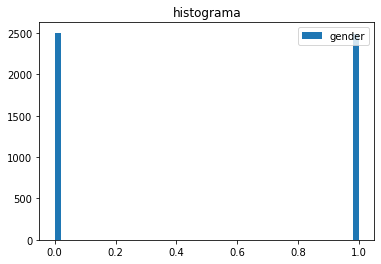

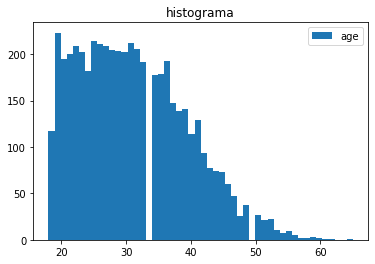

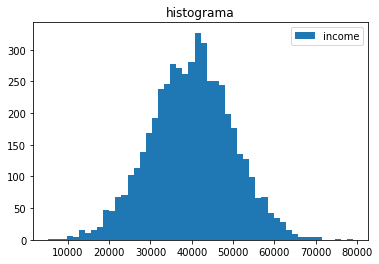

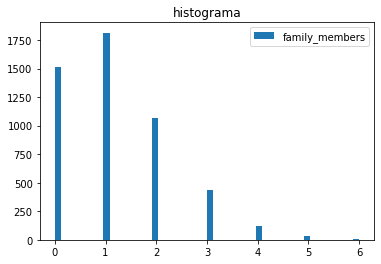

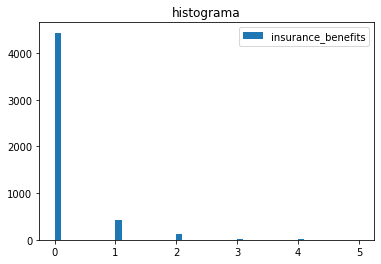

In [11]:
columns = ["gender", "age", "income", "family_members", "insurance_benefits"]

for i in columns:
    plt.hist(df[i], bins=50, label=i)
              
    plt.legend(loc="upper right")
    plt.title("histograma")
    plt.show()


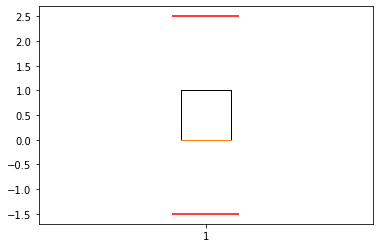

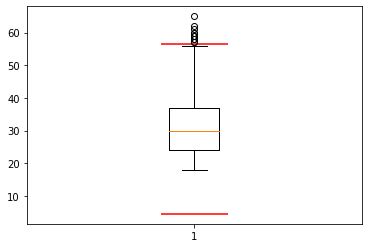

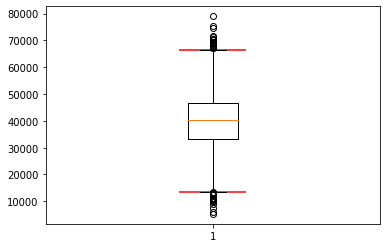

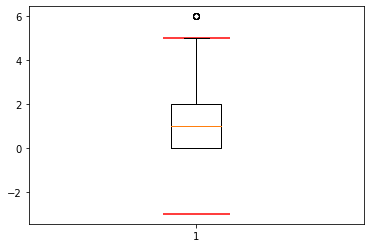

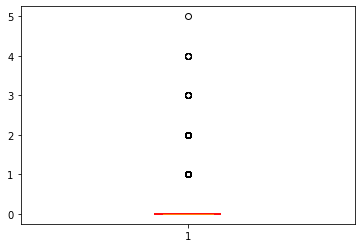

In [12]:
#construcción de boxplot para observar datos atípicos
for i in columns:
    plt.boxplot(df[i])
    Q1_inf = df[i].quantile(0.25)
    Q3_sup = df[i].quantile(0.75) 
    QR = Q3_sup - Q1_inf
    Q1 = Q1_inf - 1.5*QR
    Q3 = Q3_sup + 1.5*QR
    plt.hlines(y=[Q1,Q3], xmin = 0.9, xmax = 1.1, color = 'red')
    plt.show()

De las gráficas se observa:
1. Para la columna "gender" la distribución se muestra en los valores puntuales 0 y 1 y no hay datos dudosos. Se aprecia que practicamente hay la misma cantidad de mujeres que hombres.
2. Para la columna "age" la distribución de datos es asimétrica con cola hacia la derecha, la mayor concentración de datos se encuentra entre los 18 y 37 años. En el boxplot se aprecia presencia de datos atípicos por encima de los 55 años.
3. La columna "income" muestra una distribución normal con la media muy cercana a la mediana. Hay valores atípicos por debajo de 15000 y por encima de 68000.
4. La columna "family_members" muestra distribución puntual con mayor frecuencia entre 0 y 2, ya se aprecia menor cantidad de datos en familias con miembros mayor a 3.
5. La columna "insurance_beneficts" muestra que la mayor cantidad de clientes no han recibido beneficio y por boxplot se observa que todos aquellos valores mayores a 1 son considerados atípicos.
6. Se eliminaron 153 datos duplicados quedando un DataFrame de 4847 registros.

In [13]:
#revisión de columnas
df["gender"].value_counts(normalize=True)

0    0.501
1    0.499
Name: gender, dtype: float64

In [14]:
df["age"].value_counts(normalize=True)

19    0.0446
25    0.0428
31    0.0424
26    0.0422
22    0.0418
27    0.0418
32    0.0412
28    0.0408
29    0.0406
30    0.0404
23    0.0404
21      0.04
20     0.039
36    0.0386
33    0.0382
24    0.0364
35    0.0358
34    0.0354
37    0.0294
39    0.0282
38    0.0278
41    0.0258
18    0.0234
40    0.0228
42    0.0186
43    0.0154
44    0.0148
45    0.0146
46     0.012
47    0.0094
49    0.0074
50    0.0054
48    0.0052
52    0.0044
51    0.0042
53    0.0022
55    0.0018
54    0.0014
56     0.001
59    0.0006
60    0.0004
57    0.0004
58    0.0004
65    0.0002
61    0.0002
62    0.0002
Name: age, dtype: Float64

In [15]:
df["family_members"].value_counts(normalize=True)

1    0.3628
0    0.3026
2    0.2142
3    0.0878
4    0.0248
5    0.0064
6    0.0014
Name: family_members, dtype: float64

In [16]:
df["insurance_benefits"].value_counts(normalize=True)

0    0.8872
1    0.0846
2    0.0230
3    0.0036
4    0.0014
5    0.0002
Name: insurance_benefits, dtype: float64

## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

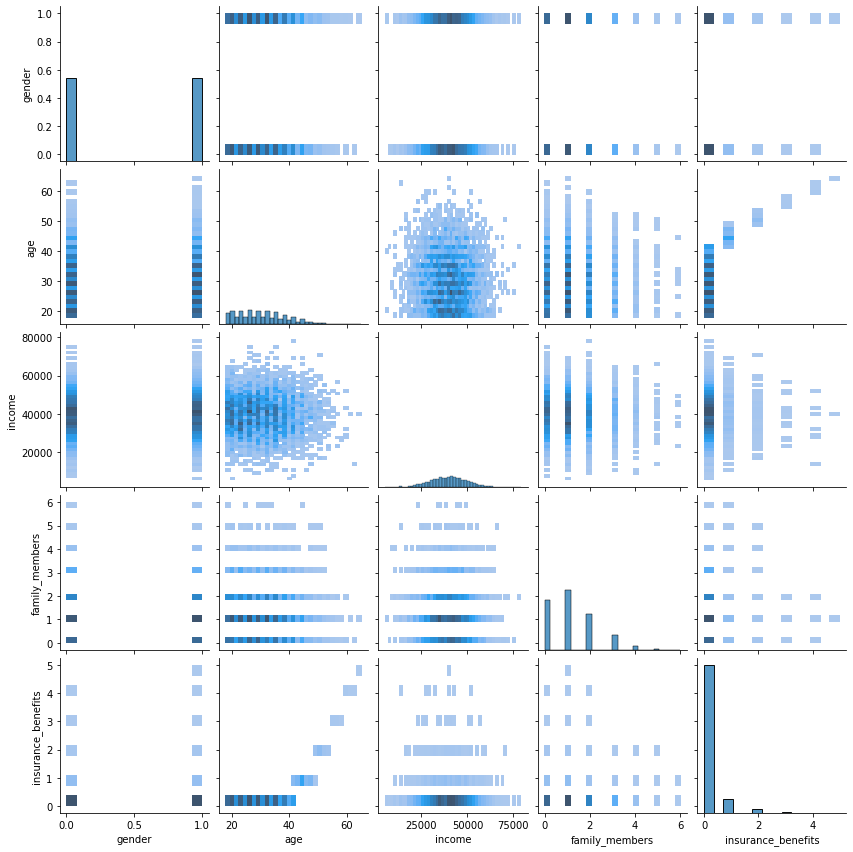

In [17]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

# Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos.
Es posible que quieras revisar las siguientes lecciones (capítulo -> lección)- Distancia entre vectores -> Distancia euclidiana
- Distancia entre vectores -> Distancia Manhattan

Para resolver la tarea, podemos probar diferentes métricas de distancia.

Escribe una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el número de prestaciones de seguro recibidas.
Puedes utilizar una implementación ya existente del algoritmo kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) o tu propia implementación.
Pruébalo para cuatro combinaciones de dos casos- Escalado
  - los datos no están escalados
  - los datos se escalan con el escalador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- Métricas de distancia
  - Euclidiana
  - Manhattan

Responde a estas preguntas:- ¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?- ¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?

In [18]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [19]:
def get_knn(df, n, k, metric):
    
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar    :param n: número de objetos para los que se buscan los vecinos más cercanos    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia    """

    nbrs = NearestNeighbors(n_neighbors = k, metric = metric).fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Escalar datos.

In [20]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [21]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
2393,0.0,0.461538,0.705063,0.000000,0
1263,0.0,0.676923,0.608861,0.000000,1
29,0.0,0.323077,0.534177,0.333333,0
3093,1.0,0.446154,0.850633,0.166667,0
4539,1.0,0.400000,0.636709,0.000000,0


Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

In [22]:
knn_no_escalado_eu = get_knn(df, 14, 10, 'euclidean')

knn_no_escalado_eu.sort_values(by="distance")

,gender,age,income,family_members,insurance_benefits,distance
14,0,40,43700.0,1,0,0.000000
2832,0,38,43700.0,0,0,2.236068
1060,1,42,43700.0,3,0,3.000000
334,0,43,43700.0,3,1,3.605551
4185,0,36,43700.0,0,0,4.123106
4568,0,44,43700.0,2,1,4.123106
1238,1,44,43700.0,0,1,4.242641
312,1,33,43700.0,2,0,7.141428
2450,1,33,43700.0,2,0,7.141428
3922,1,30,43700.0,2,0,10.099505


In [23]:
knn_escalado_eu = get_knn(df_scaled, 14, 10, 'euclidean')

knn_escalado_eu.sort_values(by="distance")

,gender,age,income,family_members,insurance_benefits,distance
14,0.0,0.615385,0.553165,0.166667,0,0.000000
2949,0.0,0.615385,0.549367,0.166667,0,0.003797
3577,0.0,0.615385,0.568354,0.166667,0,0.015190
347,0.0,0.600000,0.539241,0.166667,0,0.020750
2457,0.0,0.630769,0.536709,0.166667,0,0.022527
3406,0.0,0.630769,0.532911,0.166667,0,0.025434
922,0.0,0.600000,0.579747,0.166667,0,0.030713
1014,0.0,0.584615,0.548101,0.166667,0,0.031183
3017,0.0,0.615385,0.584810,0.166667,0,0.031646
1453,0.0,0.600000,0.525316,0.166667,0,0.031815


In [24]:
knn_no_escalado_ma = get_knn(df, 14, 10, 'manhattan')

knn_no_escalado_ma.sort_values(by="distance")

,gender,age,income,family_members,insurance_benefits,distance
14,0,40,43700.0,1,0,0.0
2832,0,38,43700.0,0,0,3.0
1060,1,42,43700.0,3,0,5.0
334,0,43,43700.0,3,1,5.0
4568,0,44,43700.0,2,1,5.0
4185,0,36,43700.0,0,0,5.0
1238,1,44,43700.0,0,1,6.0
2450,1,33,43700.0,2,0,9.0
312,1,33,43700.0,2,0,9.0
3833,1,29,43700.0,1,0,12.0


In [25]:
knn_escalado_ma = get_knn(df_scaled, 14, 10, 'manhattan')

knn_escalado_ma.sort_values(by="distance")

,gender,age,income,family_members,insurance_benefits,distance
14,0.0,0.615385,0.553165,0.166667,0,0.000000
2949,0.0,0.615385,0.549367,0.166667,0,0.003797
3577,0.0,0.615385,0.568354,0.166667,0,0.015190
347,0.0,0.600000,0.539241,0.166667,0,0.029309
3017,0.0,0.615385,0.584810,0.166667,0,0.031646
2457,0.0,0.630769,0.536709,0.166667,0,0.031840
3406,0.0,0.630769,0.532911,0.166667,0,0.035638
1014,0.0,0.584615,0.548101,0.166667,0,0.035833
922,0.0,0.600000,0.579747,0.166667,0,0.041967
1453,0.0,0.600000,0.525316,0.166667,0,0.043233


Text(0, 0.5, 'Densidad')

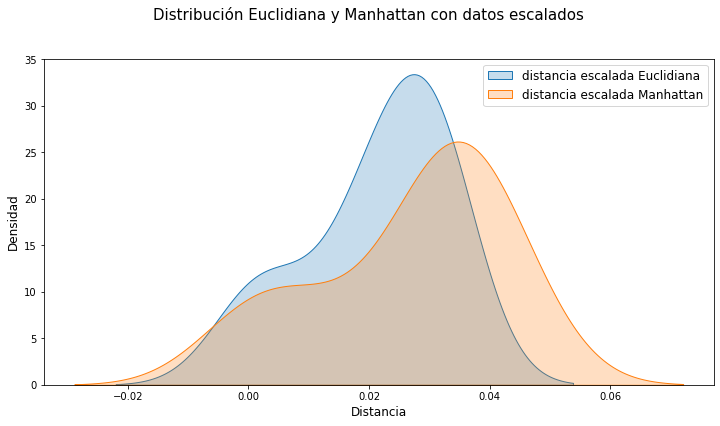

In [26]:
#Gráfico comparativo de distancias escaladas
fig = plt.figure(figsize=(12, 6))
fig.suptitle("Distribución Euclidiana y Manhattan con datos escalados", fontsize=15, y=1)
sns.kdeplot(knn_escalado_eu["distance"], fill=True, label="distancia escalada Euclidiana")
sns.kdeplot(knn_escalado_ma["distance"], fill=True, label="distancia escalada Manhattan")
plt.legend(fontsize=12)
plt.xlabel("Distancia", fontsize=12)
plt.ylabel("Densidad", fontsize=12)

Text(0, 0.5, 'Densidad')

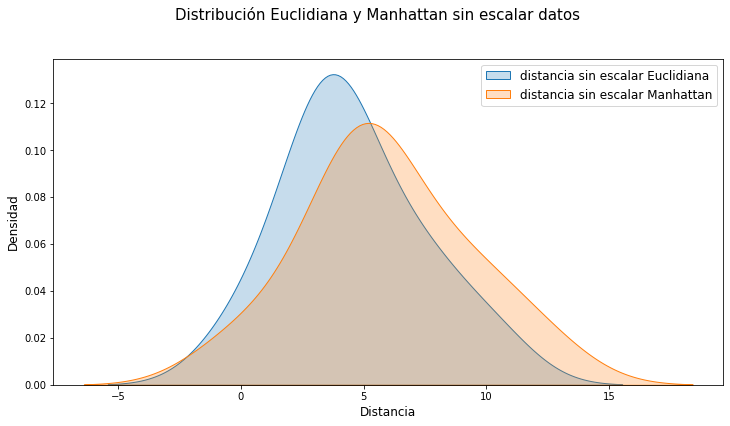

In [27]:
#Gráfico comparativo de distancias sin escalar
fig = plt.figure(figsize=(12, 6))
fig.suptitle("Distribución Euclidiana y Manhattan sin escalar datos", fontsize=15, y=1)
sns.kdeplot(knn_no_escalado_eu["distance"], fill=True, label="distancia sin escalar Euclidiana")
sns.kdeplot(knn_no_escalado_ma["distance"], fill=True, label="distancia sin escalar Manhattan")
plt.legend(fontsize=12)
plt.xlabel("Distancia", fontsize=12)
plt.ylabel("Densidad", fontsize=12)

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?** 

Sí, afecta el hecho de que las características no sean escaladas, dado que el algoritmo KNN en el cálculo de la distancia involucra a las características en todo su rango de variación y al ser este rango tan amplio, las distancias se hacen mayores, tal como se aprecia en la gráfica, se alcanza con el vecino más alejado una distancia Manhattan de hasta 12 y 10 Euclidiana.

Al escalar la data, ya la variación no es notoria y los valores de distancia se hacen menores y hasta se observa para los vecinos más cercanos que tanto la distancia Euclidiana como la Manhattan reproducen los mismos valores, ampliándose el rango hacia la Manhattan a valores más alejados.

Lo que si es cierto, es que tanto para valores escalados como no escalados, los vecinos más cercanos fueron los mismos detectados por la distancia Euclidiana y la distancia Manhattan, solo una excepción en la Manhatan no escalada que fue el registro 3725 en lugar del 3812 detectado por la Euclidiana.

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

Los resultados difieren un poco, más notorio en los datos no escalados. La distancia Manhattan es mayor que los valores calculados por la distancia Euclidiana.

# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, evalúa si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.
Instrucciones:
- Construye un clasificador basado en KNN y mide su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. Sería interesante observar cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia. Puedes utilizar una implementación ya existente del algoritmo de clasificación kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) o tu propia implementación.- Construye un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.
La probabilidad de pagar cualquier prestación del seguro puede definirse como
$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [28]:
# сalcula el objetivo
df['insurance_benefits_received'] = (df["insurance_benefits"]>0).astype(int)


In [29]:
# comprueba el desequilibrio de clases con value_counts()

df["insurance_benefits_received"].value_counts(normalize=True)

0    0.8872
1    0.1128
Name: insurance_benefits_received, dtype: float64

Como se observa hay un desequilibrio de clases, ya que la mayor proporción la ocupa el grupo que no ha recibido ningún beneficio (88%).

In [30]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# si tienes algún problema con la siguiente línea, reinicia el kernel y ejecuta el cuaderno de nuevo 
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusión')
    print(cm)
    return f1_score

In [31]:
# generar la salida de un modelo aleatorio

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [32]:
result_al = []
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df))  
        
    f=eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    result_al.append([P,f])
    
    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusión
[[0.8872 0.    ]
 [0.1128 0.    ]]

La probabilidad: 0.11
F1: 0.12
Matriz de confusión
[[0.7914 0.0958]
 [0.0994 0.0134]]

La probabilidad: 0.50
F1: 0.20
Matriz de confusión
[[0.456  0.4312]
 [0.053  0.0598]]

La probabilidad: 1.00
F1: 0.20
Matriz de confusión
[[0.     0.8872]
 [0.     0.1128]]



In [33]:
#separación de las muestras no escaladas
features_ns = df[feature_names]
target_ns = df["insurance_benefits_received"]
features_ns_train, features_ns_test, target_ns_train, target_ns_test = train_test_split(features_ns, target_ns, test_size=0.3, random_state=12345)

In [34]:
#separación de las muestras escaladas
df_scaled["insurance_benefits_received"]=df["insurance_benefits_received"]
features_s = df_scaled[feature_names]
target_s = df_scaled["insurance_benefits_received"]
features_s_train, features_s_test, target_s_train, target_s_test = train_test_split(features_s, target_s, test_size=0.3, random_state=12345)

In [35]:
#evaluación del modelo knn
result_ns = []
#f1 = []
for k in range(1,11):
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(features_ns_train, target_ns_train)
    predictions_ns = model.predict(features_ns_test)
    f1_score_ns = eval_classifier(target_ns_test, predictions_ns)
    result_ns.append([k, f1_score_ns])
    #f1.append(f1_score_ns)


F1: 0.61
Matriz de confusión
[[0.87       0.02133333]
 [0.052      0.05666667]]
F1: 0.41
Matriz de confusión
[[0.88733333 0.004     ]
 [0.08       0.02866667]]
F1: 0.41
Matriz de confusión
[[0.88       0.01133333]
 [0.078      0.03066667]]
F1: 0.28
Matriz de confusión
[[0.88866667 0.00266667]
 [0.09066667 0.018     ]]
F1: 0.27
Matriz de confusión
[[0.88533333 0.006     ]
 [0.09066667 0.018     ]]
F1: 0.11
Matriz de confusión
[[0.89       0.00133333]
 [0.102      0.00666667]]
F1: 0.11
Matriz de confusión
[[0.88866667 0.00266667]
 [0.102      0.00666667]]
F1: 0.07
Matriz de confusión
[[0.89133333 0.        ]
 [0.10466667 0.004     ]]
F1: 0.08
Matriz de confusión
[[0.89133333 0.        ]
 [0.104      0.00466667]]
F1: 0.00
Matriz de confusión
[[0.89133333 0.        ]
 [0.10866667 0.        ]]


In [36]:
result_s = []
for k in range(1,11):
    model_scaled = KNeighborsClassifier(n_neighbors = k)
    model_scaled.fit(features_s_train, target_s_train)
    predictions_s = model_scaled.predict(features_s_test)
    f1_score_s = eval_classifier(target_s_test, predictions_s)
    result_s.append([k, f1_score_s])

F1: 0.97
Matriz de confusión
[[0.88866667 0.00266667]
 [0.00466667 0.104     ]]
F1: 0.93
Matriz de confusión
[[8.90666667e-01 6.66666667e-04]
 [1.40000000e-02 9.46666667e-02]]
F1: 0.95
Matriz de confusión
[[0.88933333 0.002     ]
 [0.00866667 0.1       ]]
F1: 0.91
Matriz de confusión
[[0.88933333 0.002     ]
 [0.01666667 0.092     ]]
F1: 0.92
Matriz de confusión
[[0.88666667 0.00466667]
 [0.01133333 0.09733333]]
F1: 0.90
Matriz de confusión
[[0.89       0.00133333]
 [0.018      0.09066667]]
F1: 0.92
Matriz de confusión
[[0.88733333 0.004     ]
 [0.01266667 0.096     ]]
F1: 0.90
Matriz de confusión
[[0.88866667 0.00266667]
 [0.01733333 0.09133333]]
F1: 0.92
Matriz de confusión
[[0.88866667 0.00266667]
 [0.01466667 0.094     ]]
F1: 0.88
Matriz de confusión
[[0.88866667 0.00266667]
 [0.02133333 0.08733333]]


In [37]:
resultado_sl= pd.DataFrame(result_s, columns=["k", "f1_score"])
resultado_nsl= pd.DataFrame(result_ns, columns=["k", "f1_score"])
resultado_comb = resultado_sl.merge(resultado_nsl, on="k")
resultado_comb

,k,f1_score_x,f1_score_y
0,1,0.965944,0.607143
1,2,0.928105,0.405660
2,3,0.949367,0.407080
3,4,0.907895,0.278351
4,5,0.924051,0.271357
5,6,0.903654,0.114286
6,7,0.920128,0.112994
7,8,0.901316,0.071006
8,9,0.915584,0.082353
9,10,0.879195,0.000000


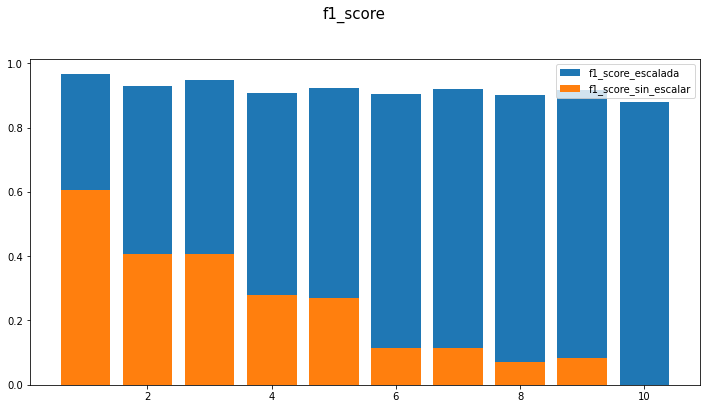

In [38]:
#grafica de resultados
fig, ax = plt.subplots(figsize=(12,6))
fig.suptitle("f1_score", fontsize=15, y=1) 
ax.bar(resultado_comb["k"], resultado_comb["f1_score_x"], label="f1_score_escalada")
ax.bar(resultado_comb["k"], resultado_comb["f1_score_y"], label= "f1_score_sin_escalar")
ax.legend(loc="best")

In [39]:
resultado_al= pd.DataFrame(result_al, columns=["P", "f1_score"])
resultado_al

,P,f1_score
0,0.0000,0.000000
1,0.1128,0.120721
2,0.5000,0.198079
3,1.0000,0.202732


<BarContainer object of 4 artists>

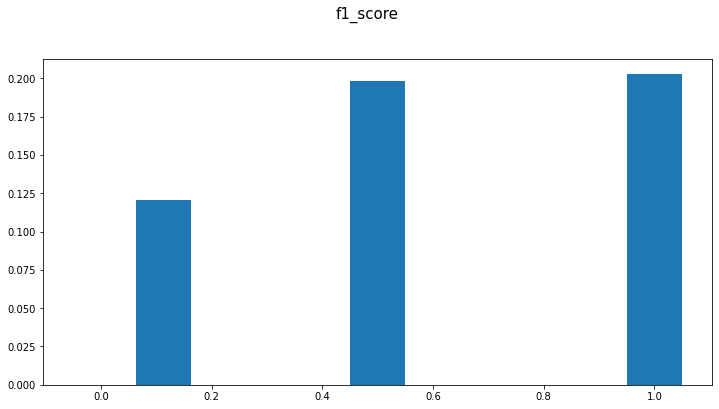

In [40]:
#grafica de resultados aleatorios
fig, ax = plt.subplots(figsize=(12,6))
fig.suptitle("f1_score", fontsize=15, y=1) 
ax.bar(resultado_al["P"], resultado_al["f1_score"], width=0.1)


Se observa que los valores de f1 más altos obtenidos son los que provienen de la data escalada y con el modelo Knn. El modelo aleatorio muestra valores de f1 muy bajos por debajo de 0.21 lo que lo hace un mal predictor.
En conclusión el modelo knn con datos escalado es bueno haciendo predicciones.

# Tarea 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, evalúa cuál sería la RECM de un modelo de regresión lineal.

Construye tu propia implementación de regresión lineal. Para ello, recuerda cómo está formulada la solución de la tarea de regresión lineal en términos de LA. Comprueba la RECM tanto para los datos originales como para los escalados. ¿Puedes ver alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades- $y$ — objetivo (un vector)- $\hat{y}$ — objetivo estimado (un vector)- $w$ — vector de pesos
La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:
$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ w que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:
$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos
$$
\hat{y} = X_{val}w
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30. Utiliza la métrica RECM para evaluar el modelo.

In [41]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        weights = (np.linalg.inv(X2.T.dot(X2))).dot(X2.T).dot(y)
        self.weights = weights[1:]
        self.w0 = weights[0]

    def predict(self, X):
        
        # añadir las unidades
        X2 = X
        y_pred = (X2).dot(self.weights) + self.w0
        
        return y_pred

In [42]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [43]:
X = (df[['age', 'gender', 'income', 'family_members']].to_numpy()).astype("i")
y = (df['insurance_benefits'].to_numpy()).astype("i")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[ 3.57495491e-02  1.64272730e-02 -2.60745684e-07 -1.16902138e-02]
RMSE: 0.34
R2: 0.66


In [44]:
Xs = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
ys = df_scaled['insurance_benefits'].to_numpy()

Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(Xs_train, ys_train)
print(lr.weights)

ys_test_pred = lr.predict(Xs_test)
eval_regressor(ys_test, ys_test_pred)

[ 2.32372069  0.01642727 -0.02059875 -0.07014128]
RMSE: 0.34
R2: 0.66


Se puede observar que no hay variación en RMSE y R2 con la data original y la escalada, es decir no se ve afectada por la escalada de datos, solo se alcanza a observar que el valor de los pesos si cambia.

# Tarea 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Trata de hacerlo y comprueba cómo quedarán los valores de las características después de la transformación. Por cierto, la propiedad de invertibilidad es importante aquí, así que asegúrate de que $P$ sea realmente invertible.

Puedes revisar la lección 'Matrices y operaciones matriciales -> Multiplicación de matrices' para recordar la regla de multiplicación de matrices y su implementación con NumPy.

In [45]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [46]:
X = df_pn.to_numpy()

Generar una matriz aleatoria $P$.

In [47]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobar que la matriz P sea invertible

In [48]:
np.linalg.inv(P)

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

In [49]:
X_ofuscacion = X.dot(P)
df_ofuscacion = pd.DataFrame(X_ofuscacion, columns = personal_info_column_list)
df_ofuscacion.head()

,gender,age,income,family_members
0,6359.715273,22380.404676,18424.090742,46000.69669
1,4873.294065,17160.36703,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.83156,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378


¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?

Como se puede observar, resulta complicado obtener los datos originales de los clientes.

¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles

In [50]:
X_revertida = X_ofuscacion.dot(np.linalg.inv(P))
df_revertida = pd.DataFrame(X_revertida, columns = personal_info_column_list)
df_revertida.head()

,gender,age,income,family_members
0,1.0,41.0,49600.0,1.0
1,-0.0,46.0,38000.0,1.0
2,-0.0,29.0,21000.0,-0.0
3,-0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,0.0


Muestra los tres casos para algunos clientes- Datos originales
- El que está transformado- El que está invertido (recuperado)

In [51]:
df.loc[24]

gender                             0.0
age                               21.0
income                         40400.0
family_members                     3.0
insurance_benefits                 0.0
insurance_benefits_received        0.0
Name: 24, dtype: Float64

In [52]:
df_ofuscacion.loc[24]

gender              5179.70008
age               18218.548245
income            14997.554355
family_members    37458.494616
Name: 24, dtype: object

In [53]:
df_revertida.loc[24]

gender               -0.0
age                  21.0
income            40400.0
family_members        3.0
Name: 24, dtype: object

Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?

Se puede apreciar que definitivamente el DataFrame con los datos enmascarados es totalmente diferente, encontrándose valores para el género y la edad fuera de contexto, esto se debe a que para llegar allí se tuvo que realizar la multiplicación por una matríz aleatoria y justamente con el método de ofuscación se busca proteger la información de los clientes.

Ahora bien, la comparación del DataFrame original con el DataFrame reconvertido difiere en algunas cantidades o signos, esto muy posiblemente se debe al redondeo de las cifras durante las operaciones involucradas.

## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal. Tu siguiente tarea es demostrar _analytically_ que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos. ¿Lo puedes creer? Pues no hace falta que lo creas, ¡tienes que que demostrarlo!

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior? 

¿Cuáles serían los valores predichos con $w_P$? 

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?
Revisa el Apéndice B Propiedades de las matrices al final del cuaderno. ¡Allí encontrarás fórmulas muy útiles!

No es necesario escribir código en esta sección, basta con una explicación analítica.

**Respuesta**

$$
w_P =(P)^{-1}(X^T X)^{-1} X^Ty \quad \Rightarrow \quad w_P = P^{-1} w
$$

**Prueba analítica**

$$
w_P =((XP)^T XP)^{-1} (XP)^Ty  
$$

de acuerdo a la propiedad de reversibilidad de la transposición de un producto de matrices: $(AB)^T = B^TA^T$  y sustituyendo en nuestra ecuación:  

$$
w_P = (P^T X^T X P)^{-1}P^T X^T y    \quad \Rightarrow \quad     w_P = [(P^T X^T X)P]^{-1} P^T X^T y
$$

si ahora aplicamos la propiedad distributiva de las matrices $(AB)C = A(BC)$

$$
w_P = P^{-1}(P^T X^T X)^{-1}P^T X^T y \quad \Rightarrow \quad w_P = P^{-1}[P^T(X^T X)]^{-1}P^T X^T y
$$
          
aplicando la propiedad de identidad multiplicativa $(AB)^{-1} = B^{-1} A^{-1}$ , $A^{-1} A = A A^{-1} = I$ y $IA = AI = A$

$$
w_P = P^{-1}(X^T X)^{-1}(P^T)^{-1} X^T y \quad \Rightarrow \quad w_P = P^{-1}(X^T X)^{-1} I X^T y \quad \Rightarrow \quad w_P = P^{-1}(X^T X)^{-1} X^T y 
$$

pero como se sabe: $w = (X^T X)^{-1} X^T$ y  entonces:

$$
w_P = P^{-1}w
$$


recordando que $ \hat{y} = XPw_P $
$$
\hat{y} = XPP^{-1}w \quad \Rightarrow \quad \hat{y} = Xw
$$

Por la deducción de la ecuación, se aprecia entonces que la predicción no depende del método de ofuscación empleado.

## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.
Construye un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación. Puedes usar una implementación de regresión lineal de scikit-learn o tu propia implementación.
Ejecuta la regresión lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.- <¡ tu comentario aquí !>
- Utiliza $XP$ como la nueva matriz de características

In [54]:
#matriz aleatoria para ofuscacion
rng = np.random.default_rng(seed=42)
P_new = rng.random(size=(X.shape[1], X.shape[1]))


In [55]:
#comprobacion que la matriz P es invertida
np.linalg.inv(P_new)

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

In [56]:
lr = MyLinearRegression()

lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

RMSE: 0.34
R2: 0.66


In [57]:
#ahora se hace split sobre la data ofuscada:
X_ofuscacion_new = (X.dot(P_new)).astype("float")
X_train_ofuscada, X_test_ofuscada, y_train_ofuscada, y_test_ofuscada = train_test_split(X_ofuscacion_new, y, test_size=0.3, random_state=12345)
lr = MyLinearRegression()

lr.fit(X_train_ofuscada, y_train_ofuscada)
y_test_pred_ofuscada = lr.predict(X_test_ofuscada)
eval_regressor(y_test_ofuscada, y_test_pred_ofuscada)

RMSE: 0.34
R2: 0.66


De acuerdo a las dos corridas realizadas, se comprueba que el método de ofuscación no afecta los resultados del algoritmo de regresion lineal, ya que el RMSE y R2 obtenido en ambos casos es el mismo.

# Conclusiones

1. El DataFrame original no tiene datos ausentes, sin embargo tenía 153 datos duplicados que no fueron eliminados porque al no haber un identificador en la columna pueden ser clientes diferentes con situaciones similares.
2. El escalamiento de los datos resulta importante en la determinación de la distancia(euclidiana y Manhattan), ya que cuando no se escalaron, los datos los resultados obtenidos de f1 fueron altos en comparación a los determinados con la data escalada.
3. La distancia euclidiana arrojó valores más bajos para el vecino más cercano que la distancia manhattan.
4. El modelo knn realiza mejores predicciones que un modelo aleatorio y funciona mejor con datos escalados.
5. Las métricas de evaluación RMSE y R2 en el modelo lineal no se ven afectadas por el escalamiento de los datos.
6. El método de ofuscación no afecta los resultados obtenidos por el método de regresión lineal.


# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter.

- [x]  Jupyter Notebook está abierto
- [ ]  El código no tiene errores- [ ]  Las celdas están ordenadas de acuerdo con la lógica y el orden de ejecución
- [ ]  Se ha realizado la tarea 1
    - [ ]  Está presente el procedimiento que puede devolver k clientes similares para un cliente determinado
    - [ ]  Se probó el procedimiento para las cuatro combinaciones propuestas    - [ ]  Se respondieron las preguntas sobre la escala/distancia- [ ]  Se ha realizado la tarea 2
    - [ ]  Se construyó y probó el modelo de clasificación aleatoria para todos los niveles de probabilidad    - [ ]  Se construyó y probó el modelo de clasificación kNN tanto para los datos originales como para los escalados. Se calculó la métrica F1.- [ ]  Se ha realizado la tarea 3
    - [ ]  Se implementó la solución de regresión lineal mediante operaciones matriciales    - [ ]  Se calculó la RECM para la solución implementada- [ ]  Se ha realizado la tarea 4
    - [ ]  Se ofuscaron los datos mediante una matriz aleatoria e invertible P    - [ ]  Se recuperaron los datos ofuscados y se han mostrado algunos ejemplos    - [ ]  Se proporcionó la prueba analítica de que la transformación no afecta a la RECM    - [ ]  Se proporcionó la prueba computacional de que la transformación no afecta a la RECM- [ ]  Se han sacado conclusiones

# Apéndices

## Apéndice A: Escribir fórmulas en los cuadernos de Jupyter

Puedes escribir fórmulas en tu Jupyter Notebook utilizando un lenguaje de marcado proporcionado por un sistema de publicación de alta calidad llamado $\LaTeX$ (se pronuncia como "Lah-tech"). Las fórmulas se verán como las de los libros de texto.

Para incorporar una fórmula a un texto, pon el signo de dólar (\\$) antes y después del texto de la fórmula, por ejemplo: $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

Si una fórmula debe estar en el mismo párrafo, pon el doble signo de dólar (\\$\\$) antes y después del texto de la fórmula, por ejemplo:
$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

El lenguaje de marcado de [LaTeX](https://es.wikipedia.org/wiki/LaTeX) es muy popular entre las personas que utilizan fórmulas en sus artículos, libros y textos. Puede resultar complicado, pero sus fundamentos son sencillos. Consulta esta [ficha de ayuda](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) (materiales en inglés) de dos páginas para aprender a componer las fórmulas más comunes.

## Apéndice B: Propiedades de las matrices

Las matrices tienen muchas propiedades en cuanto al álgebra lineal. Aquí se enumeran algunas de ellas que pueden ayudarte a la hora de realizar la prueba analítica de este proyecto.

<table>
<tr>
<td>Distributividad</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>No conmutatividad</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Propiedad asociativa de la multiplicación</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Propiedad de identidad multiplicativa</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversibilidad de la transposición de un producto de matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>